# Esercizio 3 - Sequence tree

#### Helper functions

In [20]:
from datetime import timedelta
import os
from datetime import datetime
import itertools
import random
import math
random.seed(1)

# Takes a timedelta and prints it in a human-readable format.
def format_timedelta(td: timedelta) -> str:
    days = td.days
    years, days = divmod(days, 365)
    months, days = divmod(days, 30)
    hours, remainder = divmod(td.seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    
    formatted_str = ""
    if years:
        formatted_str += f"{years}y "
    if months:
        formatted_str += f"{months}mo "
    if days:
        formatted_str += f"{days}d "
    if hours:
        formatted_str += f"{hours}h "
    if minutes:
        formatted_str += f"{minutes}m "
    if seconds:
        formatted_str += f"{seconds}s "
    

    
    return formatted_str[:-1] if formatted_str else "0s"
  
# Given a set with binary classes, computes entropy
def compute_entropy(dataset_Y):
    ones = len(list(filter(lambda classification : classification == 1,dataset_Y)))
    zeros = len(list(filter(lambda classification : classification == -1,dataset_Y)))

    if(ones == 0 or zeros==0):
        return 0
    
    entropy = ones/len(dataset_Y)*math.log2(1/(ones/len(dataset_Y))) + zeros/len(dataset_Y)*math.log2(1/(zeros/len(dataset_Y)))

    return entropy

# returns a list of tuples (i,x) where i is the index of the patient in the dataset and x is a timedelta of per quanto tempo abbiamo rilevazioni
def find_durations(dataset):
    lengths = []
    for entry in dataset:
        min_t = datetime.max
        max_t = datetime.min
        for item in entry:
            if item[0] < min_t:
                min_t = item[0]
            elif item[0] > max_t:
                max_t = item[0]
        lengths.append(max_t-min_t)
    return [(i, x) for i, x in enumerate(lengths)]

# Find al possible d,l couples that I could split the tree on. Note: Ds are randomly/evenly selected bc otherwise I'd end up with ~36000 pairs...
def create_pairs(dataset_X:list,dataset_ST:list,howmany_d =30,random_sampling=False):

    #1. Create all labels available from current
    labels = set()
    for i in range(0,len(dataset_X)):
        for item in dataset_X[i]:
            if (item[0] > dataset_ST[i]):# Only consider label if it's not been superato
                labels.add(item[1])


    #2. Find all d
    durations = set()
    if random_sampling:
        durations = set()
        for i in range(0,len(dataset_X)):
            for item in dataset_X[i]:
                if (item[0] > dataset_ST[i]): # Only consider timestamp if it's not been superato
                    durations.add(item[0]-dataset_ST[i])
        if len(durations)>howmany_d:
            durations = random.sample(sorted(durations),howmany_d) # Is this ok?
        else:
            durations = sorted(durations)
    else:
        durations = set()
        for i in range(0,len(dataset_X)):
            for item in dataset_X[i]:
                durations.add(item[0]-dataset_ST[i])
        delta = max(durations)/(howmany_d+1)
        durations = set()
        for i in range(1,howmany_d+1):
            durations.add(delta*i)

    return sorted(list(itertools.product(durations,labels)))

# Given a d,l couple, split the dataset and return indexes of true and false entries.
def test_event(dataset_X,dl_pair,dataset_ST):
    i_T = [] # indexes of entries that have label==l within d time
    i_F = [] # indexes of entries that have DON'T HAVE label==l within d time
    d,l = dl_pair


    #1. Separate entries that satisfy event test from those who don't
    for i in range(0,len(dataset_X)):
        entry = dataset_X[i]
        found=False

        for item in entry:
            #print(item)
            if(found is False and item[0]>=dataset_ST[i] and item[0]<=(dataset_ST[i]+d) and item[1]==l ):
                found=True

        if(found):
            i_T.append(i)
        else:
            i_F.append(i)
    return i_T,i_F


#### Loading and parsing DS

In [21]:
def load_diabetes_dataset(verbose=False)-> list: 
    folder_path="datasets\\diabetes"
    dataset = []
    errcount=0
    print(f"-- DS loader")

    for filename in os.listdir(folder_path):

        file_path = os.path.join(folder_path, filename)

        if os.path.isfile(file_path)and filename.startswith('data'):
            entry=[]

            with open(file_path, 'r') as file:
                content = file.readlines()
                for line in content:
                    item = tuple((line[0:-1] if line.endswith('\n') else tuple(line)).split("\t"))

                    # If the item is valid, append it to the entry
                    try:
                        item_f = datetime.strptime(item[0]+" "+item[1], "%m-%d-%Y %H:%M")
                        entry.append((item_f,item[2],item[3]))
                    except:
                        if(verbose):
                            print(f"\t[!] Entry {item} in file {filename} is NOT vallid. Skipped!")
                        errcount+=1
                # add the entry to the dataset
                dataset.append(entry)
    print(f"\tSkipped {errcount} items for formatting issues in data file. {len(dataset)} loaded.")
    return dataset

def compute_datasets(dataset:list,observation_window,waiting_window,prediction_window):

    dataset_X = []
    dataset_Y = []
    
    dataset_ST = [entry[0][0] for entry in dataset ]

    count_excluded=0

    for i in range(0,len(dataset)):
        entry = dataset[i]

        end_obs = dataset_ST[i]+observation_window
        
        start_pred = end_obs + waiting_window
        end_pred = start_pred + prediction_window

        if end_pred < entry[-1][0]:
            entry_X = []
            found = 0

            for item in entry:
                if item[0]>= dataset_ST[i] and item[0]<end_obs:
                    entry_X.append(item)
                if item[0]>=start_pred and item[0]<end_pred:
                    # put Y=1 if it has at least one "65" entry
                    if (item[1]=="65"):
                        found = 1
            dataset_X.append(entry_X)
            dataset_Y.append(found)

        else:
            count_excluded+=1
    
    dataset_ST = [entry[0][0] for entry in dataset_X ]
    dataset_V = [None]*len(dataset_X)
    print(f"-- DS builder")
    print(f"\t{count_excluded} entries unsuitable for selected windows.")
    print(f"\tFinal dataset size: {len(dataset_X)}. Classes: {sum(1 for c in dataset_Y if c == 1)}|{sum(1 for c in dataset_Y if c == 0)}, entropy {float(compute_entropy(dataset_Y)):4.3}")    
    return dataset_X,dataset_Y,dataset_ST,dataset_V

# Quick reload if needed for testing/showcasing purposes
def reload_ds():
    # prepare
    dataset = load_diabetes_dataset(False)
    observation_window = timedelta(days=+3)
    waiting_window = timedelta(days=+0)
    prediction_window = timedelta(days=+10)

    dataset_X,dataset_Y, dataset_ST,dataset_V = compute_datasets(dataset,observation_window,waiting_window,prediction_window,)
    return dataset_X[:-1],dataset_Y[:-1], dataset_ST[:-1],dataset_V[:-1]
# Setting up datasets for Boosting task

def reload_boosting():
    dataset_X,dataset_Y, dataset_ST,dataset_V = reload_ds()
    dataset_Y = [(1 if x==1 else -1) for x in dataset_Y] 

    return  dataset_X,dataset_Y, dataset_ST,dataset_V
#print_dataset_state(dataset_X,dataset_Y,dataset_ST,dataset_V,dataset_W)

def print_dataset_state(dataset_X,dataset_Y,dataset_ST,dataset_V,dataset_W=None,indexes=None):
    print("--DS state")
    if (indexes and len(indexes)>len(dataset_X)):
        indexes=None
    
    
    print("index\tX\tY\tST\t\t\tV","\tW" if dataset_W else "")

    if indexes is None:
        indexes = range(0,len(dataset_X))

    for i in indexes:
        uneaten = [entry for entry in dataset_X[i] if entry[0] >= dataset_ST[i]]
        print(f"{i}\tl.{len(uneaten)}\t{dataset_Y[i]}\t{dataset_ST[i]}\t{dataset_V[i]}\t{dataset_W[i] if dataset_W else "file="}",)
    print(f"# entries: {len(dataset_X)}, entropy={float(compute_entropy(dataset_Y)):4.3}")

### SequenceTree definition and functions.

In [22]:
# information gain for weighted samples
# (weight, label)
l = [[(2.3, 1),(4.3, 1), (8.3, 1), (3, -1),( 0.9, 1 ), (99, -1) ],[(99, 1),(8.3, 1), (1.3, -1), (2.3, -1), (9,1)]]
import pandas as pd
from math import log2


def weighted_entropy(lp):
    df = pd.DataFrame([{"w":x[0], "l":x[1]} for x in lp])
    try:
        return (df.groupby("l").sum() / df["w"].sum())["w"].apply(lambda x: -x * log2(x)).sum(), df["w"].sum()
    except:
        print(lp)

def weighted_ig(split,verbose=False):
    e, w = weighted_entropy(split[0] + split[1])
    e0, w0  = weighted_entropy(split[0])
    e1, w1  = weighted_entropy(split[1])
    if verbose:
        print(f"before split: e{e:4.2}, w{w:4.2}")
        print(f"after split: e0 {e0 :4.2} w0 {w0 :4.2} / e1 {e1 :4.2} w1 {w1 :4.2}")
    return e - (w0 / w) * e0 - (w1 / w) * e1

In [23]:
def compute_weighted_majority(dataset_Y,weights,i_F,verbose=False):
    classification=0
    for i in i_F:
        classification += dataset_Y[i]*weights[i]
    
    if verbose:
        print("votes for final classification:",classification/weights[i])

    else:
        classification = -1 if classification < 0 else 1
    return classification

In [24]:
from treelib import Tree,Node

class SequenceTrunk(Tree):

    #  -- FUNDAMENTALS

    def __init__(self, tree=None, deep=False, node_class=None, identifier=None):
        super(SequenceTrunk, self).__init__(tree=tree, deep=deep, node_class=node_class, identifier=identifier)

    # Library has a bug that won't show trees correctly unless stdout=False is added.
    def display(self):
        print(self.show(stdout=False))

    #  -- NEW NODE GENERATION

    # Let's override original create_node method in order to add new constraints such as child node number and true/false branchs.
    def create_node(self, tag=None, identifier=None, parent=None, data=None,branch=None):
        """
        Create a child node for the given @parent node. If ``identifier`` is absent,
        a UUID will be generated automatically.
        """
        
        new_node = super(SequenceTrunk, self).create_node(tag=tag, parent=parent, data=data)
        siblings = super(SequenceTrunk,self).siblings(new_node.identifier)
        
        if len(super(SequenceTrunk,self).siblings(new_node.identifier))>=2:
           raise ValueError("Parent node already has maximum number of children")

        if branch in [x.data["branch"] for x in siblings]:
           raise ValueError(f"Parent node already has a {branch} branch")
        
        return new_node
    
    def create_node_event(self,data,parent=None,branch=None,entropy="",size=0,ig="",index="",weight=0.0):
        branch_f = "" if (branch is None) else str(branch)+" "
        tag =  f"\x1b[32m⬤ {branch_f} ({str(data[1])},{format_timedelta(data[0])})\x1b[0m - [e={float(entropy):4.2} ig={float(ig):4.2} w={float(weight):4.2}] [n={size}] {index}"
        data = {"branch":branch, "dl":(data[0],data[1]),"entropy":entropy,"ig":ig,"index":index,"weights":weights}

        return     self.create_node(tag,data=data,parent=parent,branch=branch)

    def create_node_value(self,label_value,parent=None,branch=None,entropy="",size=0,ig="",index="",weight=0.0):
        branch_f = "" if (branch is None) else branch+" "
        tag =  f"\x1b[31m■ {branch_f} ({label_value}) \x1b[0m- [e={float(entropy):2.2} ig={ig:4.2} w={float(weight):4.2}] [n={size}] {index}"
        data = {"branch":branch,"value":label_value,"entropy":entropy,"index":index,"weights":weights}
        return     self.create_node(tag,data=data,parent=parent,branch=branch)

    def create_node_class(self,classification,parent=None,branch=None,entropy="",size=0,index="",weight=0.0):
        branch_f = "" if (branch is None) else str(branch)+" "

        tag =  f"\x1b[33m◆ {branch_f} {classification} \x1b[0m- [e={float(entropy):2.2} w={float(weight):4.2}] \x1b[33m[n={size}]\x1b[0m - {index}"

        # If the classsification had "max length reached", remove the tag from data
        if isinstance(classification, str):
            classification = int(classification[0])

        data = {"branch":branch, "class":classification,"entropy":entropy,"index":index,"weights":weights}


        return     self.create_node(tag,data=data,parent=parent,branch=branch)

    #  -- EVENT TESTING

    # Given a d,l couple, split the dataset in two and update starting times and dataset values.
    def perform_event_test(self,max_dl,indexes,dataset_X,ds_ST,dataset_V,verbose=False):
        # divide dataset in t and f...
        i_T = []
        i_F = []

        d,l = max_dl
        old_dataset_ST=ds_ST.copy()
        new_dataset_ST=ds_ST.copy()
        new_dataset_V=dataset_V.copy()
        
        for i in range(0,len(ds_ST)):
            entry = dataset_X[i]
            #print("aaa")
            found=False

            for item in entry:
                #starting from the starting time, see if it exists an item with timestamp < d and label == l
                
                if(found is False and item[0]>= old_dataset_ST[i] and item[0]<=(old_dataset_ST[i]+d) and item[1]==l ): # If i'm over starting time
                    found=True
                    #print("AAAAAAAAAAAA")
                    new_dataset_ST[i] = item[0]
                    new_dataset_V[i] = item[2]
                    #print(f"new: {item[2],item[0]}")

            if(found):
                i_T.append(i)
            else:
                i_F.append(i)
                
        return i_T,i_F,new_dataset_ST,new_dataset_V

    #  -- VALUE TESTING

    # Given a d,l couple, split the dataset in two 
    def __perform_value_test(self,value,dataset_V,indexes=None):
        i_T=[]
        i_F=[]

        if indexes == None:
            indexes = range(0,len(dataset_V))

        for i in indexes:
            if dataset_V[i] <= value:
                i_T.append(i)
            else:
                i_F.append(i)
        return i_T,i_F

    #  -- FIT ALGORITHM
        
    def fit(self,d,l,v,dataset_X,dataset_Y,dataset_V,dataset_ST,weights,verbose=False):
    
        # -- ROOT NODE
        i_T,i_F = test_event(dataset_X,(d,l),dataset_ST)

        if len(i_T) == 0 or len(i_F)== 0:
            return None


        l_T = [(weights[i],dataset_Y[i]) for i in i_T]
        l_F = [(weights[i],dataset_Y[i]) for i in i_F]
        ig = weighted_ig([l_T,l_F])
        parent = self.create_node_event((d,l),None,None,weighted_entropy(l_T+l_F)[0],len(i_T)+len(i_F),ig,"",weighted_entropy(l_T+l_F)[1])

        # -- FALSE TEST LEAF
        #find maj class
        classification = compute_weighted_majority(dataset_Y,weights,i_F,verbose)
        self.create_node_class(classification,parent, "f",weighted_entropy(l_F)[0],len(i_F),i_F,weighted_entropy(l_F)[1])
        
        

        # -- TRUE TEST LEAVES
        # ---- VALUE TEST
        new_dataset_V = dataset_V.copy()
        new_dataset_ST = dataset_ST.copy()
        _,_,new_dataset_ST,new_dataset_V = self.perform_event_test((d,l),i_T,dataset_X,new_dataset_ST,new_dataset_V)
        #print(new_dataset_ST)
       
        ivalue_T, ivalue_F = self.__perform_value_test(v,new_dataset_V,i_T)
        if len(ivalue_T) == 0 or len(ivalue_F) == 0:
            return None
        

        lvalue_T = [(weights[i],dataset_Y[i]) for i in ivalue_T]
        lvalue_F = [(weights[i],dataset_Y[i]) for i in ivalue_F]
        ig_value = weighted_ig([lvalue_T,lvalue_F])
        value_node = self.create_node_value(v,parent,"t",weighted_entropy(l_T)[0],len(l_T),ig_value,i_T,weighted_entropy(l_T)[1])


        # ---- VALUE LEAVES
        classification_value_true = compute_weighted_majority(dataset_Y,weights,ivalue_T,verbose)
        classification_value_false = compute_weighted_majority(dataset_Y,weights,ivalue_F,verbose)

        self.create_node_class(classification_value_true,value_node, "t",weighted_entropy(lvalue_T)[0],len(lvalue_T),ivalue_T,weighted_entropy(lvalue_T)[1])
        self.create_node_class(classification_value_false,value_node, "f",weighted_entropy(lvalue_F)[0],len(lvalue_F),ivalue_F,weighted_entropy(lvalue_F)[1])

        return (new_dataset_ST,new_dataset_V)
    
    #  -- PREDICT ALGORITHM
    #  -- PREDICT ALGORITHM

    def __predict_r(self,entry_X,entry_ST,entry_V,node:Node,verbose=False):

        if verbose:
            print(node)
            
        # BASE CASE
        
        if node.is_leaf():
            if verbose:
                print("end")
            return node.data["class"]


        # INDUCTIVE CASE    

        children = [self.get_node(x) for x in node.successors(tree.identifier)]

        if "dl" in node.data.keys():
            if verbose:
                print("dl test")
            i_T,i_F,entry_ST,entry_V = self.perform_event_test(node.data["dl"],None,entry_X,entry_ST,entry_V)

            branch = "t" if i_T else "f"
            next_node = list(filter(lambda x : x.data["branch"]==branch,children))[0]

            return self.__predict_r(entry_X,entry_ST,entry_V,next_node)

        elif "value" in node.data.keys():
            if verbose:
                print("value test")
            i_T,i_F = self.__perform_value_test(node.data["value"][1],entry_V)
            branch = "t" if i_T else "f"
            next_node = list(filter(lambda x : x.data["branch"]==branch,children))[0]

            return self.__predict_r(entry_X,entry_ST,entry_V,next_node)

    # Given a list of new entries, computes the prediction and returns it. It also prints the confusion matrix!
    def predict(self,entry_X,entry_ST,entry_V,entry_Y,verbose=False):
        if verbose:
            print("-- Predict")
        results=[]
        root = self.get_node(self.root)


        if isinstance(dataset_V,list) and len(dataset_V)==1:
            entry_X = [entry_X]
            entry_Y = [entry_Y]
            entry_ST = [entry_ST]
            entry_V = [entry_V]
            results.append(self.__predict_r(self.entry_X,entry_ST,entry_V,root),verbose)
        else:
            for i in range(0,len(entry_ST)):
                results.append(self.__predict_r([entry_X[i]],[entry_ST[i]],[entry_V[i]],root,verbose))
        
        if verbose:
            tp = sum(1 for x, y in zip(results, entry_Y) if (x == 1 and y==1))
            tn = sum(1 for x, y in zip(results, entry_Y) if (x == 0 and y==0))
            fp = sum(1 for x, y in zip(results, entry_Y) if (x == 1 and y==0))
            fn = sum(1 for x, y in zip(results, entry_Y) if (x == 0 and y==1))

            print(f"\tP\tN\nP\t{tp}\t{fn}\nN\t{fp}\t{tn}")
            print(f"Items: {tp+tn+fp+fn}")
            print(f"Accuracy: {float((tp+tn)/(tp+tn+fp+fn)):4.3}")

        return results

In [25]:
def print_weights_status(training_W,dataset_Y,training_alpha, training_err):
    
    # Header
    print("i\t",end="")
    for i in range(0,len(training_W)):
        print(f"w{i}\t\t",end="")
    print("")

    #range_to_print = list(range(0,3))+list(range(len(dataset_Y)-3,len(dataset_Y)))
    range_to_print = range(0,len(dataset_Y))
    # Weights
    for item in range_to_print: #each row in the DS
        print(f"{item}\t",end="")
        for step in range(0,len(training_W)): # each weight
            print(f"{training_W[step][item]:4.2}",end="")
            if step!=0:
                andamento = f"{"\x1b[31m↑\033[0;37m" if training_W[step-1][item]<training_W[step][item] else "\033[0;32m↓\033[0;37m"}"
                if training_W[step-1][item]==training_W[step][item]:
                    andamento="!"
                print(andamento,end="")
            print("\t\t",end="")
        print("")

    return


#### Run everything!

In [26]:
random.seed()

dataset_X,dataset_Y, dataset_ST,dataset_V= reload_boosting()
    #_,_,new_ST,new_V = tree.perform_event_test((d,l),list(range(0,len(training_X[iteration]))),training_X[iteration],training_ST[iteration],training_V[iteration])

# Find all possible thruples of l,d,v
candidates = set()
count=0
for entry_i in range(0,len(dataset_X)):
    for item in dataset_X[entry_i]:
        if item[0] > dataset_ST[entry_i]:
            candidates.add((item[0]-dataset_ST[entry_i],item[1],item[2]))
            count+=1
            
#sample candiadtes because my computer has weak p energy
candidates = list(random.sample(list(candidates),20))

# initialize data
weights = [1/(len(dataset_Y))]*len(dataset_Y)

training_ST = [dataset_ST.copy()]
training_V = [dataset_V]
training_alphas = []
training_errors = []
training_phis= []
training_W = [weights]

for iteration in range(0,15):

    candidate_trees = []
    for candidate in candidates:
        st = SequenceTrunk()
        result = st.fit(candidate[0],candidate[1],candidate[2],dataset_X,dataset_Y,(training_V[iteration]).copy(),(training_ST[iteration]).copy(),training_W[iteration])
        if result:
            # compute tree error
            err=0
            for leaf in st.leaves():
                for i in leaf.data["index"]:
                    if not dataset_Y[i] == leaf.data["class"]:
                        err+=weights[i]
            candidate_trees.append((st,err,candidate))


    if not candidate_trees:
        print("COULDNT FIND ANY VIABLE TREES IN ITERATION. QUITTING.")
        break


    # find best tree for this iteration
    min_tuple = min(candidate_trees, key=lambda x: x[1])
    err = min_tuple[1]
    best_test = min_tuple[2]
    best_tree = min_tuple[0]

    #debug
    #min_tuple[0].display()

    # compute values and new values
    alpha = 0.5 * math.log2((1-err)/err)

    
    #compute new weights
    i_correct = []
    i_mistaken = []
    for i_entry in range(0,len(dataset_Y)):
        for leaf in min_tuple[0].leaves():
            if i_entry in leaf.data["index"]:
                if dataset_Y[i_entry] == leaf.data["class"]:
                    i_correct.append(i_entry)
                    continue
                else:
                    i_mistaken.append(i_entry)
    weights_new = [None]*len(dataset_Y)
    for i in i_mistaken:  
        weights_new[i]   =  weights[i] * math.sqrt((1-err)/err)
    for i in i_correct:
        weights_new[i]   =  weights[i] * math.sqrt((err)/(1-err))
    z = sum(weights_new)
    weights_new = [w/z for w in weights_new]    
    #print(result[0])

    #_,_,new_dataset_ST,new_dataset_V = best_tree.perform_event_test((best_test[0],best_test[1]),[],dataset_X,(training_ST[iteration]).copy(),training_V[iteration])

    # update dataset ST and V
    training_ST.append(result[0])
    training_V.append(result[1])
    training_W.append(weights_new.copy())


    training_errors.append(err)
    training_alphas.append(alpha)
    training_phis.append(best_tree)
    print(err,alpha)
print_weights_status(training_W,dataset_Y,training_alphas,training_errors)


-- DS loader
	Skipped 46 items for formatting issues in data file. 70 loaded.
-- DS builder
	2 entries unsuitable for selected windows.
	Final dataset size: 68. Classes: 31|37, entropy  0.0
0.26865671641791034 0.7223924213364483
0.23880597014925364 0.8362126709857481
0.26865671641791034 0.7223924213364483
0.23880597014925364 0.8362126709857481
0.26865671641791034 0.7223924213364483
0.23880597014925364 0.8362126709857481
0.26865671641791034 0.7223924213364483
0.23880597014925364 0.8362126709857481
0.26865671641791034 0.7223924213364483
0.23880597014925364 0.8362126709857481
0.26865671641791034 0.7223924213364483
0.23880597014925364 0.8362126709857481
0.26865671641791034 0.7223924213364483
0.23880597014925364 0.8362126709857481
0.26865671641791034 0.7223924213364483
i	w0		w1		w2		w3		w4		w5		w6		w7		w8		w9		w10		w11		w12		w13		w14		w15		
0	0.015		0.028↑		0.031↑		0.028↓		0.031↑		0.028↓		0.031↑		0.028↓		0.031↑		0.028↓		0.031↑		0.028↓		0.031↑		0.028↓		0.031↑		0.028↓		
1	0.015		0.01↓		0.0098

In [17]:
errs=[]
predictions=[]
for tree in training_phis:
    predictions.append(tree.predict(dataset_X,dataset_ST,dataset_V,dataset_Y))


for iteration in range(0,15):
    count_err = 0
    for item_i in range(0,len(dataset_Y)):
        pred=0
        for i in range(0,iteration):
            pred += training_alphas[i]*predictions[i][item_i]
        pred = -1 if pred < 0 else 1
        if pred != dataset_Y[item_i]:
            count_err+=1
    err = count_err/len(dataset_Y)
    errs.append(err)


print(predictions[0])
print(dataset_Y)
print(errs)

[-1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, 1, -1, -1, -1, -1, -1, -1, 1, -1, -1, 1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[1, -1, 1, -1, -1, -1, -1, 1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, 1, -1, 1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, 1, 1, 1, 1, 1, -1, -1, 1, -1, -1, -1, -1, -1, 1, -1, 1, -1, -1, -1, 1, -1, -1, 1, 1, -1]
[0.5373134328358209, 0.3880597014925373, 0.3880597014925373, 0.3880597014925373, 0.3880597014925373, 0.3880597014925373, 0.3880597014925373, 0.3880597014925373, 0.3880597014925373, 0.3880597014925373, 0.3880597014925373, 0.3880597014925373, 0.3880597014925373, 0.3880597014925373, 0.3880597014925373]


[0.253731343283582, 0.298507462686567, 0.253731343283582, 0.298507462686567, 0.253731343283582, 0.298507462686567, 0.253731343283582, 0.298507462686567, 0.253731343283582, 0.298507462686567, 0.253731343283582, 0.298507462686567, 0.253731343283582, 0.298507462686567, 0.253731343283582]


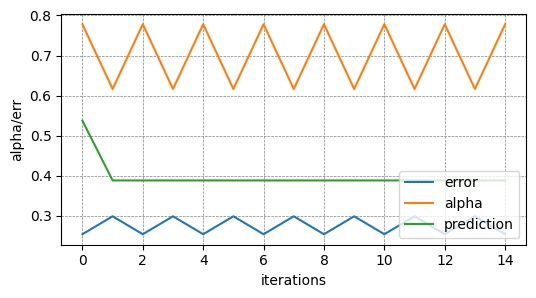

⬤  (34,1d 21h 20m) - [e= 1.0 ig=0.0089 w= 1.0] [n=67] 
├── ■ t  (040) - [e=1.0 ig=0.31 w=0.69] [n=46] [0, 4, 5, 6, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 49, 50, 51, 53, 55, 65, 66]
│   ├── ◆ f  1 - [e=0.81 w=0.42] [n=28] - [4, 8, 10, 11, 12, 14, 15, 16, 17, 18, 22, 23, 31, 32, 33, 34, 36, 37, 38, 41, 42, 43, 44, 45, 46, 49, 50, 55]
│   └── ◆ t  -1 - [e=0.5 w=0.27] [n=18] - [0, 5, 6, 9, 19, 20, 25, 26, 27, 28, 29, 30, 39, 40, 51, 53, 65, 66]
└── ◆ f  -1 - [e=0.96 w=0.31] [n=21] - [1, 2, 3, 7, 13, 21, 24, 35, 47, 48, 52, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64]

⬤  (33,1d 14h) - [e= 1.0 ig=0.03 w= 1.0] [n=67] 
├── ■ t  (014) - [e=0.99 ig=0.098 w=0.82] [n=57] [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59, 60, 61, 63, 64, 65]
│   ├── ◆ f  1 -

In [18]:
def print_alphas(training_alpha,training_errs):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6,3))  # Width, Height in inches
    # Adding labels
    plt.xlabel('iterations')
    plt.ylabel('alpha/err')
    plt.plot(training_errs,label="error")
    plt.plot(training_alpha,label="alpha")
    plt.plot(errs,label="prediction")
    _ = plt.legend(loc='lower right')
    plt.grid(color='grey', linestyle='--', linewidth=.5)
    # Displaying the plot
    plt.show()
print(training_errors)
print_alphas(training_alphas,training_errors)
for tree in training_phis:
    tree.display()

BOOSTING

In [19]:
import random
random.seed(3)

dataset_X,dataset_Y, ds_ST,dataset_V= reload_boosting()

training_W = [[1/len(dataset_Y)]*len(dataset_Y)]
training_phi = []
training_X = [dataset_X]
training_ST = [ds_ST]
training_V = [dataset_V]
training_alpha = []
training_errs = []

iTERATIONS = 10
for iteration in range(0,iTERATIONS):
    # print_dataset_state(training_X[iteration],dataset_Y,training_ST[iteration],training_V[iteration])

    #Find best trunk 
    tree, _, _ = find_best_trunk(training_X[iteration],training_ST[iteration],dataset_Y,training_V[iteration],training_W[iteration])
    training_phi.append(tree)
    
    # Compute error!
    i_correct = []
    i_mistaken = []
    errcount = 0
    if iteration > 0:

        # For each item compute prediction * alpha
        for item_i in range(0,len(dataset_Y)):
            final_response = 0
            # compute all wak predictions and sum them
            for iteration_i in range(0,iteration):
                alpha = training_alpha[iteration_i]
                prediction = alpha*training_phi[iteration_i].predict([training_X[iteration_i][item_i]],[training_ST[iteration_i][item_i]],[training_V[iteration_i][item_i]],[dataset_Y[i]])[0]
                final_response+=prediction
            
            # assign class according to final result
            final_response = 1 if final_response > 0 else -1

            #check if prediction was correct
            if final_response != dataset_Y[item_i]:
                errcount+=1
                i_mistaken.append(item_i)
            else:
                i_correct.append(item_i)

    else:
        predictions = training_phi[iteration].predict(training_X[iteration],training_ST[iteration],training_V[iteration],dataset_Y)
        
        for i in range(0,len(predictions)):
            if predictions[i]==dataset_Y[i]:
                i_correct.append(i)
            else:
                i_mistaken.append(i)
                errcount+=1
    err = (float(errcount)/len(dataset_Y))


    training_errs.append(err)
    alpha = 0.5*math.log2((1-err)/(err))


    # Compute new weights
    training_W1=[None]*len(dataset_Y)
    for index in i_correct:
        training_W1[index]=training_W[iteration][index]*(math.sqrt(err/(1-err)))
    for index in i_mistaken:
        training_W1[index]=training_W[iteration][index]*(math.sqrt((1-err)/(err)))
    z = sum(training_W1)
    training_W1 = [w/z for w in training_W1]
    training_W.append(training_W1)


    # Update dataset

    try:
        d,l = tree.get_node(tree.root).data["dl"]
    except:
        print(tree)

    _,_,new_ST,new_V = tree.perform_event_test((d,l),list(range(0,len(training_X[iteration]))),training_X[iteration],training_ST[iteration],training_V[iteration])
    training_X.append(training_X[iteration])
    training_ST.append(new_ST)
    training_V.append(new_V)
    
    training_alpha.append(alpha)

    print(f"Iteration {iteration} - alpha {alpha:4.2} - err {err}")
    print_dataset_state(training_X[iteration],dataset_Y,training_ST[iteration],training_V[iteration],indexes=list(range(0,10)))

print_weights_status(training_W,training_alpha,training_phi,dataset_Y,alpha,err)





-- DS loader
	Skipped 46 items for formatting issues in data file. 70 loaded.
-- DS builder
	2 entries unsuitable for selected windows.
	Final dataset size: 68. Classes: 31|37, entropy  0.0


NameError: name 'find_best_trunk' is not defined